# Лабараторная работа №5
# Проведение A/B тестирования

Импорты библиотек:

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
import math
from scipy import stats

### Проведём предварительную обработку данных:

Импортируем датафреймы:

In [3]:
logs_exp_df = pd.read_csv('C:/Users/dmitr/Downloads/logs_exp.csv', sep='\t')
logs_exp_df.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
orders_df = pd.read_csv('C:/Users/dmitr/Downloads/orders.csv')
orders_df.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [5]:
visitors_df = pd.read_csv('C:/Users/dmitr/Downloads/visitors.csv')
visitors_df.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Проверим датафреймы на наличие пропущеных значений:

In [6]:
print(logs_exp_df.isna().sum())

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64


In [7]:
print(orders_df.isna().sum())

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64


In [8]:
print(visitors_df.isna().sum())

date        0
group       0
visitors    0
dtype: int64


Проверим датафрейм на наличие явных дубликатов:

In [9]:
print(logs_exp_df.duplicated().sum())

413


In [10]:
logs_exp_df = logs_exp_df.drop_duplicates().reset_index()
print(logs_exp_df.duplicated().sum())

0


In [11]:
print(orders_df.duplicated().sum())

0


In [12]:
print(visitors_df.duplicated().sum())

0


Проверим датафреймы на наличие неявных дубликатов:

In [13]:
print("EventName: " + str(logs_exp_df['EventName'].unique()))
print("DeviceIDHash: " + str(logs_exp_df['DeviceIDHash'].unique()))
print("EventTimestamp: " + str(logs_exp_df['EventTimestamp'].unique()))
print("ExpId: " + str(logs_exp_df['ExpId'].unique()))
print("transactionId: " + str(orders_df['transactionId'].unique()))
print("visitorId: " + str(orders_df['visitorId'].unique()))
print("date: " + str(orders_df['date'].unique()))
print("revenue: " + str(orders_df['revenue'].unique()))
print("group: " + str(orders_df['group'].unique()))
print("date: " + str(visitors_df['date'].unique()))
print("group: " + str(visitors_df['group'].unique()))
print("visitors: " + str(visitors_df['visitors'].unique()))

EventName: ['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']
DeviceIDHash: [4575588528974610257 7416695313311560658 3518123091307005509 ...
 6660805781687343085 7823752606740475984 3454683894921357834]
EventTimestamp: [1564029816 1564053102 1564054127 ... 1565212483 1565212498 1565212517]
ExpId: [246 248 247]
transactionId: [3667963787 2804400009 2961555356 ... 1807773912 1947021204 3936777065]
visitorId: [3312258926 3642806036 4069496402 ...  370388673  573423106 2108080724]
date: ['2019-08-15' '2019-08-16' '2019-08-01' '2019-08-22' '2019-08-17'
 '2019-08-23' '2019-08-02' '2019-08-18' '2019-08-24' '2019-08-03'
 '2019-08-25' '2019-08-28' '2019-08-19' '2019-08-06' '2019-08-26'
 '2019-08-29' '2019-08-04' '2019-08-20' '2019-08-09' '2019-08-07'
 '2019-08-30' '2019-08-05' '2019-08-27' '2019-08-21' '2019-08-08'
 '2019-08-10' '2019-08-31' '2019-08-11' '2019-08-12' '2019-08-13'
 '2019-08-14']
revenue: [   1650     730     400    9759    2308    

Преобразуем данные с датами к формату datetime:

In [14]:
logs_exp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   index           243713 non-null  int64 
 1   EventName       243713 non-null  object
 2   DeviceIDHash    243713 non-null  int64 
 3   EventTimestamp  243713 non-null  int64 
 4   ExpId           243713 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 9.3+ MB


In [15]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [16]:
orders_df['date'] = pd.to_datetime(orders_df['date'])
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [17]:
visitors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [18]:
visitors_df['date'] = pd.to_datetime(visitors_df['date'])
visitors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Обработка данных завершена

Посмотрим, есть ли пересекающие пользователи в таблице orders и удалим их:

In [19]:
orders_df_A = orders_df[orders_df['group'] == 'A']
orders_df_B = orders_df[orders_df['group'] == 'B']

for indexA, rowA in orders_df_A.iterrows():
    for indexB, rowB in orders_df_B.iterrows():
        if rowA['visitorId'] == rowB['visitorId']:
            orders_df = orders_df.drop(orders_df[orders_df["visitorId"] == rowA['visitorId']].index)
            continue

Создадим массив уникальных пар значений дат и групп теста:

In [20]:
datesGroups = orders_df[['date','group']].drop_duplicates()
datesGroups.head(5)

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


Получим агрегированные кумулятивные данные по дням о заказах:

In [21]:
ordersAK = datesGroups.apply(lambda x: orders_df[np.logical_and(orders_df['date'] <= x['date'], orders_df['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
ordersAK.head(5)

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854


Получим агрегированные кумулятивные данные по дням о посетителях:

In [22]:
visitorsAK = datesGroups.apply(lambda x: visitors_df[np.logical_and(visitors_df['date'] <= x['date'], visitors_df['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])
visitorsAK.head(5)

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


Объединим полученные данные в одной таблице:

In [23]:
cumulativeData = ordersAK.join(visitorsAK.drop(['date', 'group'], axis=1))
cumulativeData.rename(columns={'transactionId': 'orders', 'visitorId': 'byers'}, inplace=True)
cumulativeData.head(5)

,date,group,orders,byers,revenue,visitors
55,2019-08-01,A,23,19,142779,719
66,2019-08-01,B,17,17,59758,713
175,2019-08-02,A,42,36,234381,1338
173,2019-08-02,B,40,39,221801,1294
291,2019-08-03,A,66,60,346854,1845


Разделим cumulativeData на cumulativeRevenueA и cumulativeRevenueB – для группы А и B:

In [24]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B']

Получим 90, 95, 99 перцентили числа заказов на пользователя:

In [25]:
ordersByUsers = orders_df.groupby('visitorId')['transactionId'].count().sort_values(ascending = False).reset_index()
ordersByUsers.rename(columns={'transactionId': 'orders'}, inplace=True)
ordersByUsers

,visitorId,orders
0,3967698036,3
1,249864742,3
2,2108163459,3
3,2988190573,3
4,3908431265,3
...,...,...
968,1438226485,1
969,1452540367,1
970,1455323168,1
971,1455861274,1


In [26]:
print("90 перцентиль: " + str(np.percentile(ordersByUsers['orders'], 90)))
print("95 перцентиль: " + str(np.percentile(ordersByUsers['orders'], 95)))
print("99 перцентиль: " + str(np.percentile(ordersByUsers['orders'], 99)))

90 перцентиль: 1.0
95 перцентиль: 1.0
99 перцентиль: 2.0


**Вывод:** 90 и 95 перцентили оказались равными 1, что означает, что 95% пользователей совершили не больше 1 заказа. Значение 99 перцентиля равное 2 означает, что 99% пользователей совершили не более двух заказов.

### Часть 2

In [27]:
logs_exp_df.head(5)

,index,EventName,DeviceIDHash,EventTimestamp,ExpId
0,0,MainScreenAppear,4575588528974610257,1564029816,246
1,1,MainScreenAppear,7416695313311560658,1564053102,246
2,2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,3,CartScreenAppear,3518123091307005509,1564054127,248
4,4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Выведем на экран количество каждого события в порядке убывания частоты (event_name) и определим какое событие встречается чаще всего:

In [28]:
logs_exp_df.groupby('EventName')['index'].count().sort_values(ascending = False).reset_index()

,EventName,index
0,MainScreenAppear,119101
1,OffersScreenAppear,46808
2,CartScreenAppear,42668
3,PaymentScreenSuccessful,34118
4,Tutorial,1018


Чаще всего встречалось событие MainScreenAppear

Подсчитаем сколько пользователей совершали каждое из этих событий, используйте groupby, agg({ 'user_id':'nunique'}):

In [29]:
logs_exp_df.groupby('EventName').agg({'DeviceIDHash': ['nunique']})

,DeviceIDHash
,nunique
EventName,
CartScreenAppear,3749
MainScreenAppear,7439
OffersScreenAppear,4613
PaymentScreenSuccessful,3547
Tutorial,847


Определим количество пользователей в каждой группе (246, 247, 248):

In [30]:
logs_exp_df.groupby('ExpId')['DeviceIDHash'].count()

ExpId
246    80181
247    77950
248    85582
Name: DeviceIDHash, dtype: int64

Проведём А/А тест:
- Нулевая гипотеза: Группа 246 и 247 не имеет различий
- Альтернативная гипотеза: Группа 246 и 247 отличаются

In [31]:
def test_groups(group_a, group_b, event, alpha):
    #получим количество успехов
    group_users = np.array([logs_exp_df.query('EventName == @event and ExpId == @group_a').DeviceIDHash.nunique(), logs_exp_df.query('EventName == @event and ExpId == @group_b').DeviceIDHash.nunique()])
    #получим количество пользователей в группах
    total_users = np.array([logs_exp_df.query('ExpId == @group_a').DeviceIDHash.nunique(), logs_exp_df.query('ExpId == @group_b').DeviceIDHash.nunique()])
    # пропорция успехов в первой группе:
    p1 = group_users[0]/total_users[0]
    # пропорция успехов во второй группе:
    p2 = group_users[1]/total_users[1]
    # пропорция успехов в комбинированном датасете:
    p_combined = (group_users[0] + group_users[1]) / (total_users[0] + total_users[1])
    # разница пропорций в датасетах
    difference = p1 - p2
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1 /total_users[0] + 1 / total_users[1]))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: есть значимая разница между долями')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [32]:
test_groups(246, 247, 'MainScreenAppear', 0.05)
test_groups(246, 247, 'OffersScreenAppear', 0.05)
test_groups(246, 247, 'CartScreenAppear', 0.05)
test_groups(246, 247, 'PaymentScreenSuccessful', 0.05)
test_groups(246, 247, 'Tutorial', 0.05)

p-значение:  0.5856639791209877
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.3233225048227193
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.19817540651836918
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.10902546202332886
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.8756574258016974
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Исходя из результата принимаем нулевую гипотезу об отсутствии значимой разницы между долями для всех событий

Проведём А/B тест:
- Нулевая гипотеза: Нет различиий между группой А (246) и группой B (248).
- Альтернативная: Есть различия между контрольной и экспериментальной группами.

In [33]:
test_groups(246, 248, 'MainScreenAppear', 0.05)
test_groups(246, 248, 'OffersScreenAppear', 0.05)
test_groups(246, 248, 'CartScreenAppear', 0.05)
test_groups(246, 248, 'PaymentScreenSuccessful', 0.05)
test_groups(246, 248, 'Tutorial', 0.05)

p-значение:  0.39774960182882513
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2531656758489338
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.10534150642722295
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.23403912852637143
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.8962914725257976
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По результатам принимаем нулевую гипотезу об отсутствии различий между группой А (246) и группой B (248)

**Вывод:** В ходе выполнения лабораторной работы были изучены алгоритмы для проведения A/B тестирования для принятия решений. Для подтверждения корректности механизма проведения A/B-теста перед ним было проведено A/A тестирование, которое выявило отсутствие значимой разницы между долями для всех событий в файле logs_exp.csv. Также были получены 90, 95, 99 перцентили числа заказов на пользователя по таблице orders.csv.

### Дополнительное задание
1 вариант и A/B тестирование для объединённых данных

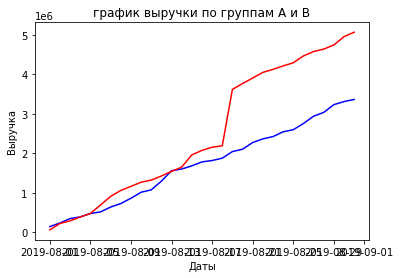

In [48]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B']

A_Datas = cumulativeRevenueA.sort_values(by='date')['date'].values
B_Datas = cumulativeRevenueB.sort_values(by='date')['date'].values
A_Revenues = cumulativeRevenueA.sort_values(by='date')['revenue'].values
B_Revenues = cumulativeRevenueB.sort_values(by='date')['revenue'].values

plt.plot(A_Datas, A_Revenues, label='Группа A',color='blue')
plt.plot(B_Datas, B_Revenues, label='Группа B',color='red')
plt.title('график выручки по группам А и B')
plt.ylabel('Выручка')
plt.xlabel('Даты')
plt.show()

In [50]:
logs_exp_df.loc[logs_exp_df['ExpId'] == 247, 'ExpId'] = 246
test_groups(246, 248, 'MainScreenAppear', 0.05)
test_groups(246, 248, 'OffersScreenAppear', 0.05)
test_groups(246, 248, 'CartScreenAppear', 0.05)
test_groups(246, 248, 'PaymentScreenSuccessful', 0.05)
test_groups(246, 248, 'Tutorial', 0.05)

p-значение:  0.5067126962216841
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.4555404043137232
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2609811882648243
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6578429353593096
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.8086866211802637
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
